In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn as skl
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

## Part a

Let's start by loading in our dataset and extracting all the columns to work with them later.

In [2]:
df = pd.read_csv("data.csv")
x1 = df['x1']
x2 = df['x2']
y = df['outcome']
groups = df['group']

Now we can set up the logistic regression classifier we will be using along with the k-fold cross validation. Note that the default Logistic Regression model from scikit-learn performs $L_2$ regularizations with $C = 1.0$.

In [16]:
model = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

Now let's write a general function that runs logistic regression with k-fold cross validation on an input and output set! On a high level, this function does the following things:
1. take in dataset and splits it into $k$ folds
2. for each $k_i$ fold, fit a logistic regression model to it
3. store the accuracy and disparity for fold $k_i$
4. return the average accuracy and disparity of the model across all the folds

In [17]:
def train_and_test(X, y):
    accuracies = []
    disparities = []

    print(f"{'Fold':<10} | {'Accuracy':<12} | {'Demographic Disparity':<20}")
    print("-" * 50)

    for i, (train_index, val_index) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        group_val = groups.iloc[val_index]
        
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        
        # Calculate Accuracy
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
        
        prob_g0 = y_pred[group_val == 0].mean()
        prob_g1 = y_pred[group_val == 1].mean()
        
        disparity = abs(prob_g0 - prob_g1)
        disparities.append(disparity)
        
        print(f"{i+1:<10} | {acc:<12.4f} | {disparity:<20.4f}")

    print("-" * 40)
    print(f"{'AVERAGE':<10} | {np.mean(accuracies):<12.4f} | {np.mean(disparities):<20.4f}")

Let's run it! The $x_1, x_2$ columns are our inputs and the `outcome` column is our output.

In [18]:
train_and_test(pd.concat([x1, x2], axis=1), y)

Fold       | Accuracy     | Demographic Disparity
--------------------------------------------------
1          | 0.7250       | 0.1671              
2          | 0.7418       | 0.1948              
3          | 0.7352       | 0.1704              
4          | 0.7408       | 0.1605              
5          | 0.7350       | 0.1740              
----------------------------------------
AVERAGE    | 0.7356       | 0.1734              


## Part B

Let's compute the correlation between the $x$ columns and the `group` column.

In [23]:
corr_x1 = df['x1'].corr(df['group'])
corr_x2 = df['x2'].corr(df['group'])
print(f"Correlation between x1 and group: {corr_x1}")
print(f"Correlation between x2 and group: {corr_x2}")

Correlation between x1 and group: 0.34086419155667463
Correlation between x2 and group: 0.009020919165973784


Since the correlation between $x_1$ and `group` are higher, let's train a model without $x_1$.

In [24]:
train_and_test(x2.to_frame(), y)

Fold       | Accuracy     | Demographic Disparity
--------------------------------------------------
1          | 0.6847       | 0.0000              
2          | 0.6885       | 0.0183              
3          | 0.6897       | 0.0058              
4          | 0.6953       | 0.0175              
5          | 0.6957       | 0.0017              
----------------------------------------
AVERAGE    | 0.6908       | 0.0086              


We see that the disparity drops significantly when we don't use $x_1$ in the training. This suggests that $x_1$ is a proxy.

## Part C

The disparity formula is defined in a way that creates a cliff at the decision boundary which makes it impossible for gradient based optimization methods to guarantee optimality. To illustrate this, imagine you had some neural network model that is trying to minimize a loss function with $disp_f(D)$ as a term. If the output of the model is $0.48$ for one set of inputs, then this will get translated into an output of $0$ because of the threshold. If the model weights then update and now the output is $0.51$ for the same set of inputs, then the model output suddenly jumps up to $1$ with a minor adjustment to the weight. 

To solve this problem, we need to add a term to the loss function that measures disparity while being continuous everywhere. It would also be a bonus if we could penalize higher disparity in the model. Let's build up such a term piece by piece. To start, we will be using the BCE loss formula with logits:

$$\mathcal{L} = \mathcal{L}_{BCE} = \frac{1}{N}\sum_{i=1}^{N}[y_i \log(\sigma(x_i)) + (1-y_i)\log(1 - \sigma(x_i))]$$

- $N$ is the number of samples
- $y_i$ is the true label for the $i$-th sample (this is the `outcome' column)
- $x_i$ is the raw, unnormalized output of the model (logit)
- $\sigma(x)$ is the sigma function defined as $\sigma(x) = \dfrac{1}{1 + e^{-x}}$

The disparity term we will build up will be added as a term to $\mathcal{L}$. We will use $disp_f(D)$ as a starting point, but the key change we will make is that instead of aggressively applying a threshold to the model output into a class membership, we will instead keep the model output as the probability of a certain class membership and average these probabilities across all the samples. This new term would look something like:

$$\mathcal{D} = \frac{1}{N_0}\sum_{i\in G_0}{\sigma(x_i)} - \frac{1}{N_1}\sum_{i \in G_1}{\sigma(x_i)}$$
- $N_i$ is the number of samples in group $i$
- $G_i$ is the all the samples in group $i$
- $x_i$ is the raw, unnormalized output of the model (logit)
- $\sigma(x)$ is the sigma function defined as $\sigma(x) = \dfrac{1}{1 + e^{-x}}$

This is an appropriate continuous analog of $disp_f(D)$ that the model can optimize over, but we can force the model to minimize the selection rates between groups by squaring the mean error (this creates a convex penalty that pushes the model to $0$ disparity much faster than taking the absolute value of the difference). Thus, our final disparity term is:

$$\mathcal{D} = \left(\frac{1}{N_0}\sum_{i\in G_0}{\sigma(x_i)} - \frac{1}{N_1}\sum_{i \in G_1}{\sigma(x_i)}\right)^2$$

Now we can add this term to our loss function and scale it by $\lambda$ so that we can control how strongly our model penalizes disparity. This gives us a final loss function of:

$$\mathcal{L} = \frac{1}{N}\sum_{i=1}^{N}[y_i \log(\sigma(x_i)) + (1-y_i)\log(1 - \sigma(x_i))] + \lambda \left(\frac{1}{N_0}\sum_{i\in G_0}{\sigma(x_i)} - \frac{1}{N_1}\sum_{i \in G_1}{\sigma(x_i)}\right)^2$$

Or more concisely,

$$\mathcal{L} = \mathcal{L}_{BCE} + \lambda \mathcal{D}$$


## Part D

Let's implement the loss function we designed in part c!

In [9]:
def fairness_loss(model, X, y_true, g_train, lam):
    logits = model(X).squeeze()
    bce = nn.BCEWithLogitsLoss()
    loss = bce(logits, y_true)
    
    y_pred = torch.sigmoid(logits)
    p_pos_g0 = y_pred[g_train == 0].mean()
    p_pos_g1 = y_pred[g_train == 1].mean()
    disparity = (p_pos_g0 - p_pos_g1)**2
    
    return loss + lam * disparity

Now we will write a general function (much like we did in part a) to train our model, but we will use pytorch this time so that we can use the custom loss function we defined above.

In [10]:
def train_model(model, x_train, y_train, group_train, lam=1.0, lr=0.01, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for _ in range(epochs):
        optimizer.zero_grad()
        loss = fairness_loss(model, x_train, y_train, group_train, lam)
        loss.backward()
        optimizer.step()
    return model

While we're at it, let's also make the calculation of $disp_f(D)$ into a function that we can call once our model is trained.

In [8]:
def calc_disparity(X_val, y_val, group_val, model):
    weights_list = []
    with torch.no_grad():
        logits_val = model(X_val).squeeze()
        probs_val = torch.sigmoid(logits_val)
        y_pred = (probs_val >= 0.5).float()
        
        acc = (y_pred == y_val).float().mean().item()
        prob_g0 = y_pred[group_val == 0].mean().item()
        prob_g1 = y_pred[group_val == 1].mean().item()
        disparity = abs(prob_g0 - prob_g1)
        w = model.weight.squeeze().cpu().numpy()
        weights_list.append(w)
    # print(f"{i+1:<10} | {acc:<12.4f} | {disparity:<20.4f}")
    return acc, disparity, weights_list
    

Now we can put it all together and do the training! This function, on a high level, does the same things as `train_and_test`, but we use `pytorch` now instead of `scikit-learn`

In [11]:
def train_pytorch(input, lam):
    accuracies = []
    disparities = []
    all_weights = []

    # print(f"{'Fold':<10} | {'Accuracy':<12} | {'Demographic Disparity':<20}")
    # print("-" * 50)
    
    X_tensor = torch.tensor(input.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    groups_tensor = torch.tensor(groups.values, dtype=torch.int64)
    for i, (train_idx, val_idx) in enumerate(kf.split(input)):
        X_train, X_val = X_tensor[train_idx], X_tensor[val_idx]
        y_train, y_val = y_tensor[train_idx], y_tensor[val_idx]
        group_train, group_val = groups_tensor[train_idx], groups_tensor[val_idx]
        
        model = nn.Linear(X_train.shape[1], 1)

        model = train_model(model, X_train, y_train, group_train, lam=lam)
        
        accuracy, disparity, weights = calc_disparity(X_val, y_val, group_val, model)
        accuracies.append(accuracy)
        disparities.append(disparity)
        all_weights.append(weights)

    all_weights = np.stack(all_weights, axis=0)
    mean_weights = np.mean(all_weights, axis=0)
    mean_acc = np.mean(accuracies)
    mean_disp = np.mean(disparities)
    #print("-" * 40)
    #print(f"{'AVERAGE':<10} | {np.mean(accuracies):<12.4f} | {np.mean(disparities):<20.4f}")
    return mean_acc, mean_disp, mean_weights

This function runs through various values of $\lambda$ and creates two main plots:
1. the accuracy vs. disparity of the model as $\lambda$ changes
2. the final model weights with each $\lambda$ value

In [26]:
# Running part D for plot
def run_plot(X, title):
    accuracies_list = []
    disparities_list = []
    weights_list = []
    regs = [0, 1, 10, 100, 1000, 5000]
    regs = np.logspace(0, 4)
    
    for reg in regs:
        acc, disp, w = train_pytorch(X, reg)
        if reg == 0:
            print("When disparity strength is 0: Disparity: ", disp, "  Accuracy: ", acc)
        accuracies_list.append(acc)
        disparities_list.append(disp)
        weights_list.append(w)
    weights_array = np.stack(weights_list, axis=0)
    plt.scatter(disparities_list, accuracies_list)
    plt.xlabel('Demographic Disparity')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.grid(True)
    plt.savefig(title)
    plt.figure()
    
    for j in range(weights_array.shape[2]):
        plt.plot(
            regs,
            weights_array[:, 0, j],
            marker='o',
            label=f"Feature {j + 1}"
        )

    plt.xscale("log")
    plt.xlabel("regularization λ")
    plt.ylabel("Average weight value")
    plt.title("Feature weights vs disparity regularization")
    plt.legend()
    plt.grid(True)
    plt.show()

    return accuracies_list, disparities_list

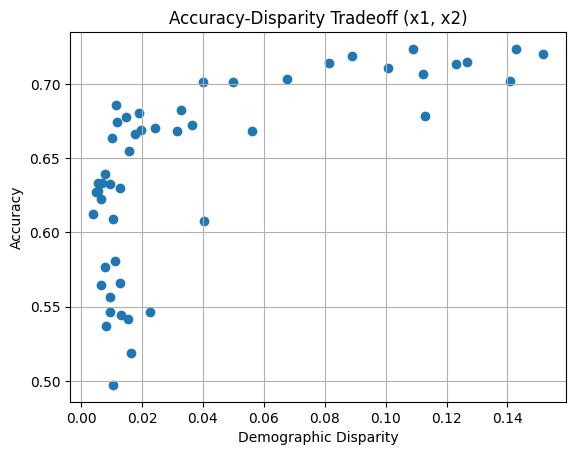

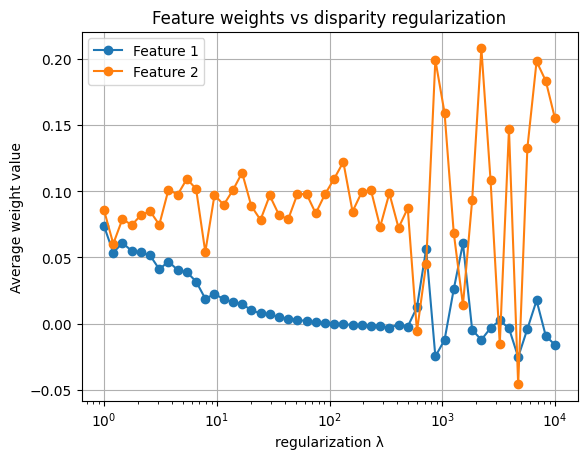

([np.float64(0.7203999996185303),
  np.float64(0.7022500038146973),
  np.float64(0.7232999920845031),
  np.float64(0.6787500023841858),
  np.float64(0.7148499965667725),
  np.float64(0.7135499954223633),
  np.float64(0.7065000057220459),
  np.float64(0.7236500024795532),
  np.float64(0.7107999920845032),
  np.float64(0.7191499829292297),
  np.float64(0.7138499975204468),
  np.float64(0.6075999975204468),
  np.float64(0.7031499981880188),
  np.float64(0.6683000087738037),
  np.float64(0.7014500021934509),
  np.float64(0.7015000104904174),
  np.float64(0.6722499966621399),
  np.float64(0.6680999875068665),
  np.float64(0.682449996471405),
  np.float64(0.6705000042915344),
  np.float64(0.6662499904632568),
  np.float64(0.6272499918937683),
  np.float64(0.6690500140190124),
  np.float64(0.655050003528595),
  np.float64(0.6805000066757202),
  np.float64(0.6781000018119812),
  np.float64(0.6856000065803528),
  np.float64(0.630050003528595),
  np.float64(0.6638500094413757),
  np.float64(0.67

In [27]:
run_plot(pd.concat([x1, x2], axis=1), "Accuracy-Disparity Tradeoff (x1, x2)")    

## Part E

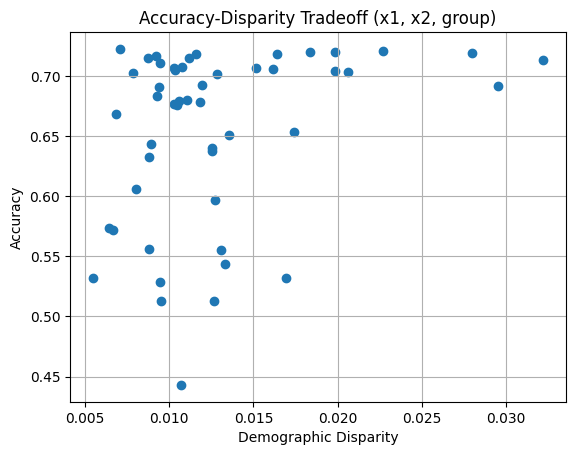

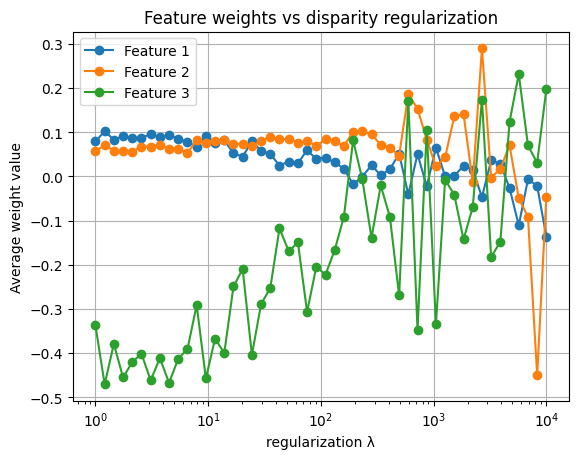

([np.float64(0.6918500065803528),
  np.float64(0.7211999893188477),
  np.float64(0.7134999871253968),
  np.float64(0.715149998664856),
  np.float64(0.7072499990463257),
  np.float64(0.7205499887466431),
  np.float64(0.7186499953269958),
  np.float64(0.7205999970436097),
  np.float64(0.7166000008583069),
  np.float64(0.7109500050544739),
  np.float64(0.7057500004768371),
  np.float64(0.7197000026702881),
  np.float64(0.7227999925613403),
  np.float64(0.703249990940094),
  np.float64(0.7188499927520752),
  np.float64(0.7015999913215637),
  np.float64(0.7041500091552735),
  np.float64(0.7154500126838684),
  np.float64(0.7064999938011169),
  np.float64(0.7077499866485596),
  np.float64(0.6927500128746032),
  np.float64(0.7050999999046326),
  np.float64(0.6783000111579895),
  np.float64(0.7027999997138977),
  np.float64(0.6766000032424927),
  np.float64(0.6833499908447266),
  np.float64(0.6793499946594238),
  np.float64(0.6512499928474427),
  np.float64(0.6382000207901001),
  np.float64(0.6

In [28]:
run_plot(pd.concat([x1, x2, groups], axis=1), "Accuracy-Disparity Tradeoff (x1, x2, group)")

## Part F

In part D, we see that the coefficient of $x_1$ (the blue line) moves towards $0$ as the $\lambda$ increases. The coefficient for $x_2$ (the orange line) is relatively stable, only diverging for larger $\lambda$ values. This makes sense because $x_1$ is correlated with group, so if the model places any weight on $x_1$, this will create disparity in the model. As we continue to increase the penalty for disparity, the convex term we added forces the model to reduce the weight of $x_1$, even though it has explanatory power.

In part E, the coefficients of $x_1, x_2$ seem to be higher than in part D, and the coefficient for `group` seems to be moving up towards $0$, after which it becomes really positive or really negative. This makes sense because the model doesn't need to just decrease the weight on $x_1$ anymore to achieve fairness. It now has the additional level of using `group` to boost the outputs for the disadvantaged group till the average predictions become equal (which we are defining as fairness.)

## Part G

Using `group` gives a better tradeoff as seen by the second graph which has more much lower disparity with the same accuracy achieved as the model that didn't use `group`. Without `group`, the model can only reduce disparity 
by becoming less sensitive to whatever correlates with `group`, but with `group`, the model 
can reduce disparity more directly and effectively, allowing us to keep a higher accuracy
at the same disparity level. In part D, the model had to sacrifice accuracy to be fair, but in part E, the model is able to use the relationship between `group` and outcome to maintain fairness and accuracy.

## Part H

Let's look at the problem of whether to give a criminal pretrial bail or to not give them bail. 
The outcome of this would be whether the person appears in court for their hearing or if they 
fail to appear in court or are rearrested before then which is binary. x1 would be a continuous
factor such as number of prior missed court appearances. x2 could be a continuous measure of 
stability or support such as employment stability calculated using number of years of past
continual employment. Group could be a binary of race, such as 'black' being 1 and 'not black'
being 0. You could use logistic regression classifier with a fairness regularization term to
prevent producing large demographic disparities to get a higher accuracy. We can tune the 
fairness regularized classifier to allow a choice between more accuracy or less demographic
disparity. Factors that we should consider when making this choice is of course accuracy of
predictions since pretrial bail has important consequences on a person's life. We also consider
demographic disparity and the transparency of the algorithm biases to judges in order for
them to make more informed decisions. 